In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# change to your working directory
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


# Setup

In [ ]:
## Import Libraries
from __future__ import absolute_import, division, print_function, unicode_literals
import os, shutil, random, glob
import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, Reshape, GlobalMaxPool2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import PIL.Image
import sklearn.model_selection as sklrn
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from termcolor import colored
import statistics
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from sklearn import metrics
from keras.models import Sequential
from keras import layers
from keras.layers import GlobalMaxPooling2D
from keras import applications
from keras import optimizers
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2
from  keras.models import Model
import tensorflow as tf
import datetime
import time
from keras import regularizers
from collections import Counter

In [ ]:
# set outlay of dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


In [ ]:
## Define Constants
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE = 128

# Preprocessing & EDA

## Train/Test split

In [ ]:
def move_to_train(train_path, image_root):
    for image in image_root:
        if not os.path.exists(os.path.join(train_path, os.path.basename(image))):
            os.rename(str(image), os.path.join(train_path, os.path.basename(image)))

def move_to_test(test_path, test_image):
    for image in test_image:
        NEW_NAME = os.path.join(test_path, os.path.basename(image))
        os.rename(str(image), NEW_NAME)

def split_train_test(path, number):
    # define original path
    path_to_images_aca = Path(f"{path}/lung_aca/")
    path_to_images_n = Path(f"{path}/lung_n/")
    path_to_images_scc = Path(f"{path}/lung_scc/")

    # define path and folder name
    TRAIN_PATH = f"{path}/train/"
    TEST_PATH = f"{path}/test/"

    # create folders
    if not os.path.exists(TRAIN_PATH):
        os.mkdir(TRAIN_PATH)
    if not os.path.exists(TEST_PATH):
        os.mkdir(TEST_PATH)

    # create lists for all files
    _images_root_aca = [fpath for fpath in path_to_images_aca.glob("*")]
    _images_root_n = [fpath for fpath in path_to_images_n.glob("*")]
    _images_root_scc = [fpath for fpath in path_to_images_scc.glob("*")]

    # create lists of files for test folder
    test_list_aca, test_list_n, test_list_scc = [], [], []
    for image in _images_root_aca:
        test_list_aca.append(str(image))
    test_images_aca = random.sample(test_list_aca, k=number)
    for image in _images_root_n:
        test_list_n.append(str(image))
    test_images_n = random.sample(test_list_n, k=number)
    for image in _images_root_scc:
        test_list_scc.append(str(image))
    test_images_scc = random.sample(test_list_scc, k=number)

    move_to_test(TEST_PATH, test_images_aca)
    move_to_test(TEST_PATH, test_images_n)
    move_to_test(TEST_PATH, test_images_scc)

    _images_aca = [fpath for fpath in path_to_images_aca.glob("*")]
    _images_n = [fpath for fpath in path_to_images_n.glob("*")]
    _images_scc = [fpath for fpath in path_to_images_scc.glob("*")]

    # move all files to train folder
    move_to_train(TRAIN_PATH, _images_aca)
    move_to_train(TRAIN_PATH, _images_n)
    move_to_train(TRAIN_PATH, _images_scc)


    print("Train/Test folder are splitted!!")

## Data Loading

In [ ]:
# set path
TRAIN_DIR="./Images/LC25000/lung_image_sets_2500_byt_mix/train/"
TEST_DIR="./Images/LC25000/lung_image_sets_2500_byt_mix/test/"
TRAIN_DIR_t="./Images/LC25000/lung_image_sets_2500_byclass/"  # for model test

# read the files name from each folder
filenames_tr = os.listdir(TRAIN_DIR)
filenames_test = os.listdir(TEST_DIR)

## Label Dataset

In [ ]:
## label traning set
categories_tr = []
for filename in filenames_tr:
    category = filename.split('.')[0].strip('0123456789')
    if category == 'lungaca':
        categories_tr.append(0)
    elif category == 'lungn':
        categories_tr.append(1)
    else:
        categories_tr.append(2)

df_tr = pd.DataFrame({
    'filename': filenames_tr,
    'label': categories_tr
})

## label test set
categories_test = []
for filename in filenames_test:
    category = filename.split('.')[0].strip('0123456789')
    if category == 'lungaca':
        categories_test.append(0)
    elif category == 'lungn':
        categories_test.append(1)
    else:
        categories_test.append(2)

df_test = pd.DataFrame({
    'filename': filenames_test,
    'label': categories_test
})

## convert label into string for using image generator with 'class_mode' set to 'categorical'
df_tr["label"] = df_tr["label"].replace({0: 'aca', 1: 'n', 2:'scc'}) 
df_test["label"] = df_test["label"].replace({0: 'aca', 1: 'n', 2:'scc'}) 
df_tr = df_tr.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

## Exploratory Data Analysis

Total training images: 6000
Total test images: 1500



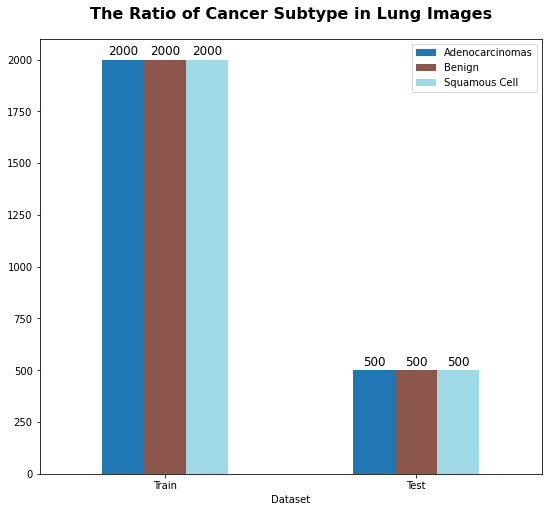

In [ ]:
# check the number of train/test images
total_train = len(filenames_tr)
total_test = len(filenames_test)
# total_train = len(filenames_tr_aca) + len(filenames_tr_n) + len(filenames_tr_scc)
# total_test = len(filenames_test_aca) + len(filenames_test_n) + len(filenames_test_scc)
print(colored("Total training images: {0}".format(total_train), attrs=['bold']))
print(colored("Total test images: {0}".format(total_test), attrs=['bold']))
print()


data=[["Train", df_tr['label'].value_counts()[0], df_tr['label'].value_counts()[1], df_tr['label'].value_counts()[2]],
      ["Test", df_test['label'].value_counts()[0], df_test['label'].value_counts()[1], df_test['label'].value_counts()[2]]
     ]

df=pd.DataFrame(data,columns=["Dataset","Adenocarcinomas", "Benign", "Squamous Cell"])
ax=df.plot(x="Dataset", y=["Adenocarcinomas", "Benign", "Squamous Cell"], kind="bar",figsize=(9,8), colormap="tab20")
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
ax.set_title("The Ratio of Cancer Subtype in Lung Images",pad=20, fontdict={'fontsize':16}, fontweight="bold")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2 , p.get_height()), ha='center', va='center',size=12, xytext=(0, 8),
                   textcoords='offset points')

plt.show()

In [ ]:
# This function shows random sample image
def show_random_sample_image(names, path, type):
    while True:
        sample = random.choice(names)
        if sample.split('.')[0].strip('0123456789') == type:
            image = load_img(os.path.join(path,sample))
            plt.imshow(image)
            #plt.title(sample.split('.')[0].strip('0123456789'))
            break
        else: 
            continue

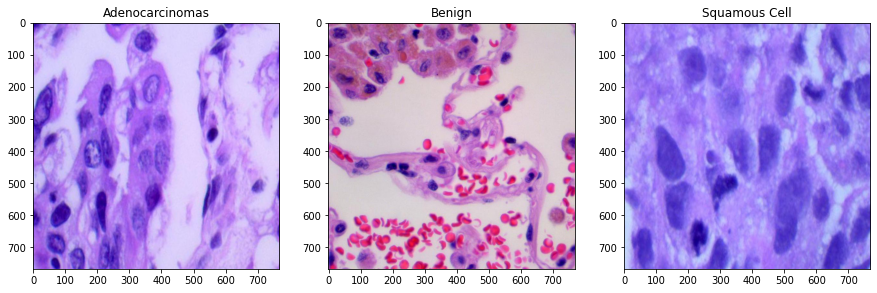

In [ ]:
plt.subplots(1,3,figsize=(15,15))
ax1=plt.subplot(1,3,1)
ax1.set_title("Adenocarcinomas")
show_random_sample_image(filenames_tr,TRAIN_DIR,"lungaca")
ax2=plt.subplot(1,3,2)
ax2.set_title("Benign")
show_random_sample_image(filenames_tr,TRAIN_DIR,"lungn")
ax3=plt.subplot(1,3,3)
ax3.set_title("Squamous Cell")
show_random_sample_image(filenames_tr,TRAIN_DIR,"lungscc")

## Data Augmentation

In [ ]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

**Image Generator for Training Dataset (categorical)**

In [ ]:
## train generator
train_datagen = ImageDataGenerator(
    rescale=1./255,              
)

train_generator = train_datagen.flow_from_dataframe(df_tr, 
                                                directory=TRAIN_DIR, 
                                                x_col='filename',
                                                y_col='label',
                                                target_size=IMAGE_SIZE,
                                                class_mode='categorical',
                                                batch_size=BATCH_SIZE
                                                )


Found 6000 validated image filenames belonging to 3 classes.


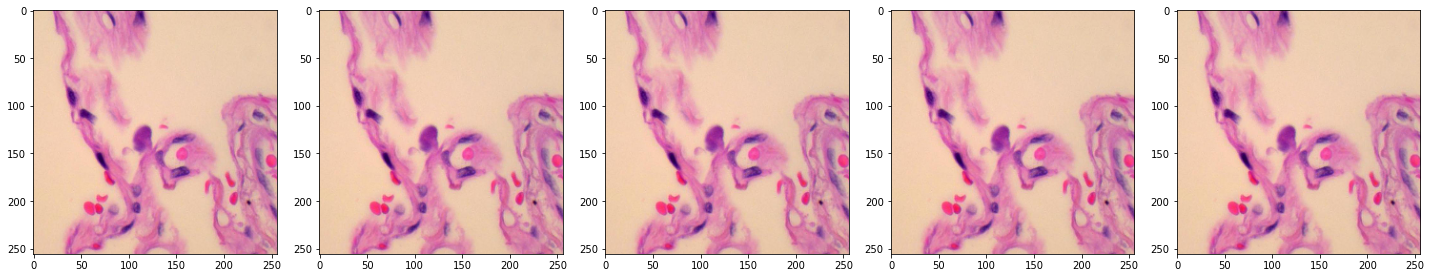

In [ ]:
# visualize these augmentations 
augmented_images = [train_generator[0][0][0] for i in range(5)]
plotImages(augmented_images)

**Image Generator for Test Dataset (categorical)**

In [ ]:
# test generator
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_dataframe(df_test,
                                                directory=TEST_DIR, 
                                                x_col='filename',
                                                y_col='label',
                                                target_size=IMAGE_SIZE,
                                                class_mode='categorical',
                                                batch_size=BATCH_SIZE,
                                                shuffle=False
                                                )

Found 1500 validated image filenames belonging to 3 classes.


## Configuration for Testing Models

**This function is to find out the best model configuration during model building.**

In [ ]:
# configuring training setting for K-fold cross validation with data augmentation
def test_model(modela, modelb, modelastr, modelbstr, train_dir, epochs, batch_size=BATCH_SIZE):
    
    scores_a = []
    scores_r = []

    train_datagen_t = ImageDataGenerator(
                                        rescale=1./255,              
                                        validation_split=0.2, 
                                        )

    train_data_gen_t = train_datagen_t.flow_from_directory(
                                                directory=train_dir, 
                                                target_size=IMAGE_SIZE,
                                                class_mode='categorical',
                                                batch_size=BATCH_SIZE,
                                                subset='training',
                                                shuffle = True
                                                )
    valid_data_gen_t = train_datagen_t.flow_from_directory(
                                                directory=train_dir, 
                                                target_size=IMAGE_SIZE,
                                                class_mode='categorical',
                                                batch_size=BATCH_SIZE,
                                                subset='validation',
                                                shuffle=False
                                                )
    

    # fit the model
    print(colored("**{0}**".format(modelastr), 'green', attrs=['bold']))
    start=time.time()
    history_a = modela.fit(train_data_gen_t,
                                epochs=epochs,
                                validation_data=valid_data_gen_t,
                                verbose=0)
        

    # plot
    plot_learning_curves(modela,history_a, [['loss', 'val_loss'],['accuracy', 'val_accuracy']]) 

    # store scores
    scores_a.append({'acc':np.average(history_a.history['accuracy']),'val_acc':np.average(history_a.history['val_accuracy']), 
                         'loss':np.average(history_a.history['loss']),'val_loss':np.average(history_a.history['val_loss'])})
    
    end = time.time()
    print("Total time used: ", round((end - start)/60,2), "minutes")


    if modelb:
        
        print(colored("**{0}**".format(modelbstr), 'green', attrs=['bold']))
        start=time.time()
        history_r = modelb.fit(train_data_gen_t,
                                epochs=epochs,
                                validation_data=valid_data_gen_t,  
                                verbose=0)
        # store scores
        scores_r.append({'acc':np.average(history_r.history['accuracy']),'val_acc':np.average(history_r.history['val_accuracy']),
                         'loss':np.average(history_r.history['loss']),'val_loss':np.average(history_r.history['val_loss'])})

        # plot
        plot_learning_curves(modelb,history_r, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])
        end = time.time()
        print("Total used time : ", round((end - start)/60,2), "minutes")
       
    else:
        scores_r= None
        pass        

    return scores_a , scores_r

## Configuration for Training Process

**This function is for ploting the learing curve of traing process.**

In [ ]:
# function for plot the learing curve of traing process
def plot_learning_curves(model,history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")

    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=12)
        ax[idx].set_xlabel('epochs ',fontsize=10)
        ax[idx].set_ylabel('value',fontsize=10)
        ax[idx].set_title(arr[idx][0] + ' and ' + arr[idx][1],fontsize=12)
    plt.show()

**This function is for configuring training setting for K-fold cross validation with data augmentation.**

In [ ]:
# configuring training setting for K-fold cross validation with data augmentation
def train_and_cross_validate(modela, modelb, modelastr, modelbstr, train_dir,  n_folds, epochs, batch_size=BATCH_SIZE):
    
    scores_a = []
    scores_r = []
    train_X = [img_fname for img_fname in os.listdir(train_dir)]
    train_X = np.array(train_X)
    train_labels = [l.split('/')[-1].split('.')[0].strip('0123456789') for l in train_X]
    train_labels = np.array(train_labels)
          
    # prepare cross validation
    kfold = sklrn.KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    FoldsSetNo = 1 
    for train_ix, valid_ix in kfold.split(train_X):
        print (colored('Folds Set # {0}'.format(FoldsSetNo), 'blue', attrs=['bold']))
        # select rows for train and valid
        xx_train, yy_train, xx_valid, yy_valid = \
           train_X[train_ix], train_labels[train_ix], train_X[valid_ix], train_labels[valid_ix]

        # flow training images in batches for the current folds set
        # for training         
        train_data_gen = train_datagen.flow_from_dataframe(
            dataframe = pd.DataFrame({'filename':xx_train,'label':yy_train}), 
            directory=train_dir, 
            x_col='filename',
            y_col='label',
            batch_size=batch_size,
            target_size=IMAGE_SIZE,
            class_mode='categorical',
            shuffle = True)
        
        # for validation         
        valid_data_gen = test_datagen.flow_from_dataframe(
            dataframe = pd.DataFrame({'filename':xx_valid,'label':yy_valid}), 
            directory=train_dir, 
            x_col='filename',
            y_col='label',
            batch_size=batch_size,
            target_size=IMAGE_SIZE,
            class_mode='categorical',
            shuffle=False)

        # fit the model
        print(colored("**model with {0} optimizer **".format(modelastr), 'green', attrs=['bold']))
        start=time.time()
        history_a = modela.fit(train_data_gen,
                                epochs=epochs,
                                validation_data=valid_data_gen,
                               steps_per_epoch=len(xx_train)//(batch_size),
                                #steps_per_epoch=int(np.ceil(len(xx_train)/float(batch_size))),
                                verbose=0)
        

        # plot
        plot_learning_curves(modela,history_a, [['loss', 'val_loss'],['accuracy', 'val_accuracy']]) 
        end = time.time()
        print("Used time: ", round((end - start)/60,2), "minutes")

        # store scores
        scores_a.append({'acc':np.average(history_a.history['accuracy']),'val_acc':np.average(history_a.history['val_accuracy']), 
                         'loss':np.average(history_a.history['loss']),'val_loss':np.average(history_a.history['val_loss'])})


        if modelb:
            print(colored("**model with {0} optimizer**".format(modelbstr), 'green', attrs=['bold']))
            start-time.time()
            history_r = modelb.fit(train_data_gen,
                                    epochs=epochs,
                                    validation_data=valid_data_gen,  
                                   steps_per_epoch=len(xx_train)//(batch_size),
                                #steps_per_epoch=int(np.ceil(len(xx_train)/float(batch_size))),
                                    verbose=0)
            # store scores
            scores_r.append({'acc':np.average(history_r.history['accuracy']),'val_acc':np.average(history_r.history['val_accuracy']),
                         'loss':np.average(history_r.history['loss']),'val_loss':np.average(history_r.history['val_loss'])})

            # plot
            plot_learning_curves(modelb,history_r, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])
            end = time.time()
            print("Used time: ", round((end - start)/60,2), "minutes")
       
        else:
            scores_r= None
            pass        

        FoldsSetNo +=1
    return scores_a , scores_r

**This function is for visualizing results of cross validation.**

In [ ]:
# function for visualizing results of cross validation
def plot_cv(modelname, socres1, scores2, FOLDS):
    train_acc_Adam, val_acc_Adam, train_loss_Adam, val_loss_Adam = [], [], [], []
    
    FOLDS_range=range(1,FOLDS+1)
    
    for s in socres1:
        train_acc_Adam.append(s['acc'])
        val_acc_Adam.append(s['val_acc'])
        train_loss_Adam.append(s['loss'])
        val_loss_Adam.append(s['val_loss'])
    print(colored("The Results of K-folder cross-validation of " + str(modelname), "blue", attrs=['bold']))
    print("Average of training accuracy of " + str(modelname) + ":", round(statistics.mean(train_acc_Adam)*100,2),"%")            
    print("Average of validation accuracy of " + str(modelname) + ":", round(statistics.mean(val_acc_Adam)*100,2),"%")   
    print("Average of training loss of " + str(modelname) + ":", round(statistics.mean(train_loss_Adam),6)) 
    print("Average of validation loss of " + str(modelname) + ":", round(statistics.mean(val_loss_Adam),6)) 
    print()
    
    if scores2:
        train_acc_RMSprop, val_acc_RMSprop, train_loss_RMSprop, val_loss_RMSprop = [], [], [], [] 
        for s in scores2:
            train_acc_RMSprop.append(s['acc'])
            val_acc_RMSprop.append(s['val_acc'])
            train_loss_RMSprop.append(s['loss'])
            val_loss_RMSprop.append(s['val_loss'])
        print("Average of training accuracy of " + str(modelname) + ":", round(statistics.mean(train_acc_RMSprop)*100,2),"%")             
        print("Average of validation accuracy of " + str(modelname) + ":", round(statistics.mean(val_acc_RMSprop)*100,2),"%")  
        print("Average of training loss of " + str(modelname) + ":", round(statistics.mean(train_loss_RMSprop),6))  
        print("Average of validation loss of " + str(modelname) + ":", round(statistics.mean(val_loss_RMSprop),6))  
    
    else:
        pass


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(FOLDS_range, train_loss_Adam, label='Training Loss_1')
    plt.plot(FOLDS_range, val_loss_Adam, label='Validation Loss_1')
    if scores2:
        plt.plot(FOLDS_range, train_loss_RMSprop, label='Training Loss_2')
        plt.plot(FOLDS_range, val_loss_RMSprop, label='Validation Loss_2')
    else:
        pass
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss_'+ str(modelname))

    plt.subplot(1, 2, 2)
    plt.plot(FOLDS_range, train_acc_Adam, label='Training Accuracy_1')
    plt.plot(FOLDS_range, val_acc_Adam, label='Validation Accuracy_1')
    if scores2:
        plt.plot(FOLDS_range, train_acc_RMSprop, label='Training Loss_2')
        plt.plot(FOLDS_range, val_acc_RMSprop, label='Validation Loss_2')
    else:
        pass
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy_' + str(modelname))
    plt.show()

## Configuration for Final-Training

In [ ]:
def plot_learning_curves_final(model,history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.set_style("whitegrid")

    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        #ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0]], fontsize=12)
        #ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=12)
        ax[idx].set_xlabel('epochs ',fontsize=10)
        ax[idx].set_ylabel('value',fontsize=10)
        #ax[idx].set_title(arr[idx][0] + ' and ' + arr[idx][1],fontsize=12)
        ax[idx].set_title(arr[idx][0], fontsize=12)
    plt.show()

In [ ]:
# configuring training setting for K-fold cross validation with data augmentation
def train_and_test_final(modela, modelb, epochs, batch_size=BATCH_SIZE):
    
    scores_a = []
    scores_r = []

    # fit the model
    #print(colored("**model with optimizer Adam**", 'green', attrs=['bold']))
    start=time.time()
    history_a = modela.fit(train_generator,
                            epochs=epochs,
                            #validation_data=test_generator,
                            steps_per_epoch=total_train//(batch_size),
                            verbose=0)
    # plot
    plot_learning_curves_final(modela,history_a, [['loss'],['accuracy']])

    scores_a.append({'acc':np.average(history_a.history['accuracy']), 
                         'loss':np.average(history_a.history['loss'])})
    end = time.time()
    print("Used time: ", round((end - start)/60,2), "minutes")


    if modelb:
        print(colored("**model with optimizer RMSprop**", 'green', attrs=['bold']))
        start=time.time()
        
        # fit the model
        history_r = modela.fit(train_generator,
                                epochs=epochs,
                                #validation_data=test_generator,
                                steps_per_epoch=total_train//(batch_size),
                                verbose=0)
        # plot
        #plot_learning_curves(modelb,history_r, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])
        plot_learning_curves_final(modelb,history_r, [['loss'],['accuracy']])

        # store scores
        scores_r.append({'acc':np.average(history_r.history['accuracy']),'loss':np.average(history_r.history['loss'])})
        end = time.time()
        print("Used time: ", round((end - start)/60,2), "minutes")
       
    else:
        scores_r= None
        pass        

    return scores_a , scores_r

## Configuration for Evaluation

In [ ]:
def evaluate_model(modela, modelb, modelnamea, modelnameb,traingen, testgen):
    #print (colored('Folds Set # {0}'.format(modelnamea), 'blue', attrs=['bold']))
    print(colored("***Results of {0}***".format(modelnamea), attrs=['bold']))
    val_scores = modela.evaluate(traingen, verbose=0)
    print('Accuracy on training data: {:.2f}% \nError on training data: {:.6f}'.format(val_scores[1]*100, 1 - val_scores[1]))   
    val_scores2 = modela.evaluate(testgen, verbose=0)
    print('Accuracy on test data: {:.2f}% \nError on test data: {:.6f}'.format(val_scores2[1]*100, 1 - val_scores2[1]))
    
    if modelb:
        print()
        print(colored("***Results of {0}***".format( modelnameb), attrs=['bold']))
        val_scores = modelb.evaluate(traingen, verbose=0)
        print('Accuracy on training data: {:.2f}% \nError on training data: {:.6f}'.format(val_scores[1]*100, 1 - val_scores[1]))   
        val_scores2 = modelb.evaluate(testgen, verbose=0)
        print('Accuracy on test data: {:.2f}% \nError on test data: {:.6f}'.format(val_scores2[1]*100, 1 - val_scores2[1]))
    else:
        pass

## Configuration for Predictor




In [ ]:
def imagenet_processing(image):
    image = image/255
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    for i in range(3):
        image[:,:,i] -= mean[i]
        image[:,:,i] /= std[i]
    return image

In [ ]:
def test_pred(folderdir, model, trurtype):
    folderlist=sorted(glob.glob(os.path.join(folderdir, "*")))
    folder_name=[]
    folder_predict=[]
    for folder in folderlist: 
        foldername=folder.split('/')[-1]
        #print(folder)
        #print(foldername)
        folder_name.append(foldername)
        predict=[]
        folder=sorted(glob.glob(os.path.join(folder, "*")))
        for links in folder:
            #print(links)
            img = tf.keras.utils.load_img(links, target_size=IMAGE_SIZE)
            x = tf.keras.utils.img_to_array(img)
            x = imagenet_processing(x)
            x = np.expand_dims(x, axis=0)
            preds = model.predict(x)
            preds=np.argmax(preds,axis=1)
            predict.append(preds[0])
        count_pre=Counter(predict).most_common()
        prediction = count_pre[0][0]
        if len(count_pre) < 2:
            prediction_f=prediction 
        else:
            if ((count_pre[0][1] == count_pre[1][1]) and (count_pre[0][0] == 0 and count_pre[1][0] == 2 )):
                prediction_f = 3
            else:
                if count_pre[0][0] == 1:
                    prediction_f=count_pre[1][0]
                else:
                    prediction_f=prediction 
            #prediction=max(set(predict),key=predict.count)   
    
        print(foldername, ": " , count_pre)
        print(foldername, ": " , predict)
        folder_predict.append(prediction_f)
        

    df_test_pred = pd.DataFrame({
        'filename': folder_name,
        'predict': folder_predict
    })

    df_test_pred["Actual"]=trurtype

    return df_test_pred

# Build Models - Transfer Learning With Fine-Tuning (ResNet50V2)

## Defining and compiling the model

In [ ]:
from tensorflow.keras.applications import ResNet50V2
# ResNet50V2
resnet50V2_model = ResNet50V2(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
                  include_top=False, weights="imagenet")

for layer in resnet50V2_model.layers[:154]:   # there is no need to retrain the first layers 
  layer.trainable = False

x = resnet50V2_model.output
x = GlobalAveragePooling2D()(x)


# Add a fully connected layer with 256 hidden units and ReLU activation
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)

# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(3, activation='softmax')(x)  # beacause we have 3 classes for categorical variables
modelres15_a = Model(resnet50V2_model.input, x) 
#, kernel_regularizer=regularizers.l2(0.1)

94683136/94668760 [==============================] - 2s 0us/step


In [ ]:
optimizer_adam = tf.keras.optimizers.Adam(lr=1e-3)
modelres15_a.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])
modelres15_a.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 ormalization)                                                                                    
                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 64, 64, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 64, 64, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
          

### Test model

Found 6000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
****model with optimizer Adam****


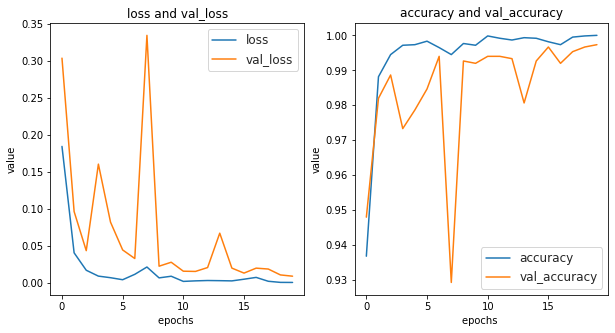

Total time used:  54.95 minutes


([{'acc': 0.9944583356380463,
   'loss': 0.0169011480465997,
   'val_acc': 0.984799998998642,
   'val_loss': 0.06784676276147365}],
 None)

In [ ]:
test_model(modela=modelres15_a, modelb=None, modelastr="**model with optimizer Adam**", modelbstr=None, train_dir=TRAIN_DIR_t, epochs=20, batch_size=BATCH_SIZE) #lr:1e-3

## Train the model with k-fold cross validation

Folds Set # 1
Found 4800 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.
**model with Adam optimizer **


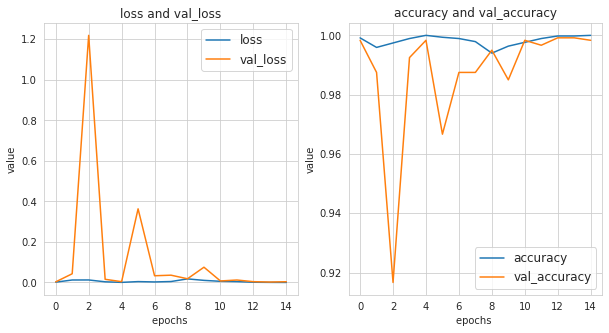

Used time:  27.15 minutes
Folds Set # 2
Found 4800 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.
**model with Adam optimizer **


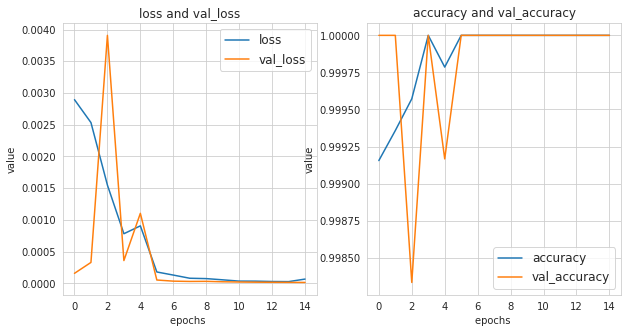

Used time:  25.46 minutes
Folds Set # 3
Found 4800 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.
**model with Adam optimizer **


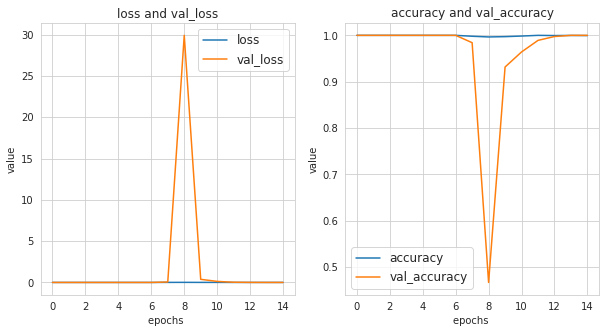

Used time:  20.15 minutes
Folds Set # 4
Found 4800 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.
**model with Adam optimizer **


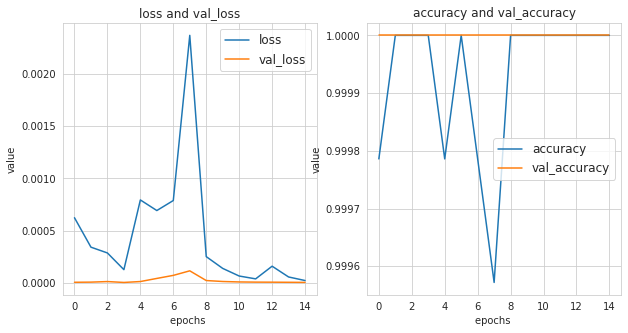

Used time:  20.1 minutes
Folds Set # 5
Found 4800 validated image filenames belonging to 3 classes.
Found 1200 validated image filenames belonging to 3 classes.
**model with Adam optimizer **


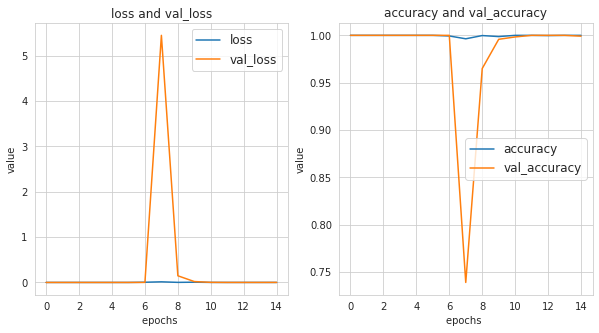

Used time:  21.45 minutes


In [ ]:
No_fold=5
scores0_a, scores0_r = train_and_cross_validate(modela= modelres15_a, modelb=None, modelastr="Adam", modelbstr=None, train_dir=TRAIN_DIR, n_folds=No_fold, epochs=15, batch_size=BATCH_SIZE)

The Results of K-folder cross-validation of ResNet50V2 (Adam)
Average of training accuracy of ResNet50V2 (Adam): 99.94 %
Average of validation accuracy of ResNet50V2 (Adam): 98.45 %
Average of training loss of ResNet50V2 (Adam): 0.00213
Average of validation loss of ResNet50V2 (Adam): 0.506241



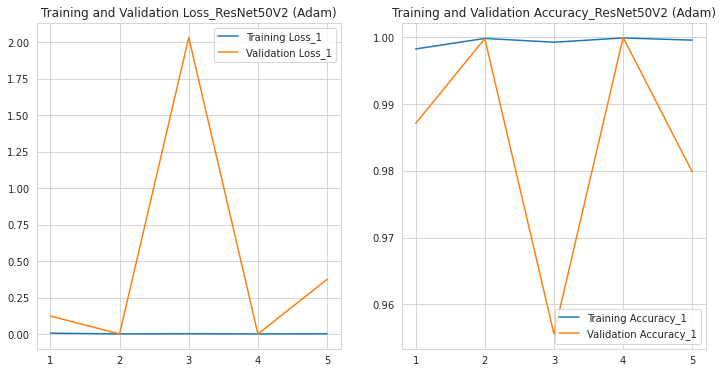

In [ ]:
plot_cv(modelname="ResNet50V2 (Adam)", socres1=scores0_a, scores2=None, FOLDS=No_fold)

In [ ]:
evaluate_model(modela=modelres15_a, modelb=None, modelnamea="ResNet50V2 (Adam)", modelnameb=None, traingen=train_generator, testgen=test_generator)

***Results of ResNet50V2 (Adam)***
Accuracy on training data: 99.98% 
Error on training data: 0.000167
Accuracy on test data: 99.87% 
Error on test data: 0.001333


## Final-training

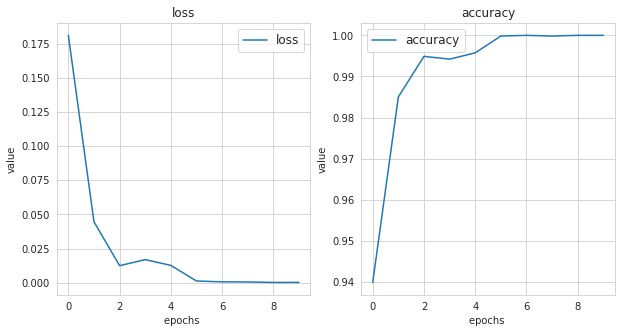

Used time:  19.93 minutes


In [ ]:
scoresf_a, scoresf_r = train_and_test_final(modela=modelres15_a, modelb=None,  epochs=10, batch_size=BATCH_SIZE) 

##### Save Models

In [ ]:
modelres15_a.save('baselinemodel_resnet50v2_Adam_p10_e-3_b128_2500i_s256.h5')
modelres15_a.save_weights('baselinemodel_resnet50v2_Adam_p10_e-3_b128_2500i_s256_w.h5')

## Evaluate the Models

### Test dataset

In [ ]:
evaluate_model(modela=modelres15_a,modelb=None, modelnamea="ResNet50V2 (Adam)", modelnameb=None, traingen=train_generator, testgen=test_generator) 

***Results of ResNet50V2 (Adam)***
Accuracy on training data: 100.00% 
Error on training data: 0.000000
Accuracy on test data: 99.80% 
Error on test data: 0.002000


In [ ]:
y_predict_a =modelres15_a.predict(test_generator, verbose=0)
y_predict_ai = np.where(y_predict_a > 0.5, 1, 0)
predicted_class_indice_a=np.argmax(y_predict_a,axis=1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions_a = [labels[k] for k in predicted_class_indice_a]

# setup for test_lable_cat 
test_label_categories=tf.keras.utils.to_categorical(test_generator.labels)

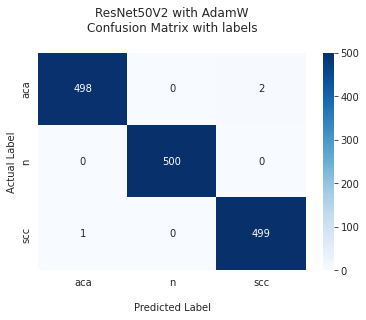

In [ ]:
import seaborn as sns
from sklearn import metrics

modelname="ResNet50V2 with AdamW"

sns.set_style("whitegrid")
 
ax = sns.heatmap(metrics.confusion_matrix(df_test["label"], predictions_a), annot=True, 
                 cmap='Blues',
                 fmt="d")

ax.set_title(f'{modelname}\nConfusion Matrix with labels\n');
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('Actual Label');
ax.xaxis.set_ticklabels(['aca','n','scc'])
ax.yaxis.set_ticklabels(['aca','n','scc'])
plt.show()

In [ ]:
print(colored(modelname, attrs=['bold']))
print("Accuracy: {0:.2f}".format(metrics.accuracy_score(df_test["label"], predictions_a)*100),"%")
print("F1 Score: {0:.3f}".format(metrics.f1_score(df_test["label"], predictions_a, average = 'weighted')))
print("Recall: {0:.3f}".format(metrics.recall_score(df_test["label"], predictions_a, average = 'weighted')))
print("Precision: {0:.3f}".format(metrics.precision_score(df_test["label"], predictions_a, average = 'weighted')))
print("Area Under the ROC: {0:.3f}".format(metrics.roc_auc_score(test_label_categories, y_predict_ai, average = 'weighted',  multi_class= 'ovr')))

ResNet50V2 with AdamW
Accuracy: 99.80 %
F1 Score: 0.998
Recall: 0.998
Precision: 0.998
Area Under the ROC: 0.999
